In [1]:
from scipy import stats

In [2]:
from scipy.special import gamma, factorial

In [3]:
import msprime
import tskit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab
import scipy.linalg
import matplotlib
import csv
import random
from itertools import groupby
import collections

### Creating 1-D Circular Migration Matrix and Setting Variables m*rho>>1

In [4]:
plt.style.use('seaborn-talk')
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['ytick.major.size'] = 10

In [5]:
def migration_matrix(length, migration_rate):
    first_col = np.zeros(length)
    first_col[1] = migration_rate
    first_col[-1] = migration_rate
    result = scipy.linalg.circulant(first_col)
    return result

In [6]:
Deme_density = 50
L = 1000 #the number of demes 
deme_sample_size = Deme_density #deme sample size 
trials = 50 #number of trials
m = 0.2 #migration rate
total_sample_size = L * deme_sample_size # total sample size
matrix = migration_matrix(L, m/2)

population_configurations = L * [msprime.PopulationConfiguration(sample_size=deme_sample_size)]

print("we want 1 <<< m*deme_density <<< number of demes to keep continous structure")
print("1 <<< ",m*Deme_density," <<< ",L )
    

we want 1 <<< m*deme_density <<< number of demes to keep continous structure
1 <<<  10.0  <<<  1000


In [7]:
afs2 = []

for i in range(trials):
    ts = msprime.simulate(Ne=Deme_density, population_configurations=population_configurations, migration_matrix=matrix)

    afs1 = ts.allele_frequency_spectrum(mode="branch", polarised=True, span_normalise=False)
    
    afs2.append(afs1)
    
    #print("iteration",i)
    
afs = np.mean(afs2, 0)

The provenance information for the resulting tree sequence is 4.90MB. This is nothing to worry about as provenance is a good thing to have, but if you want to save this memory/storage space you can disable provenance recording by setting record_provenance=False
The provenance information for the resulting tree sequence is 4.90MB. This is nothing to worry about as provenance is a good thing to have, but if you want to save this memory/storage space you can disable provenance recording by setting record_provenance=False
The provenance information for the resulting tree sequence is 4.90MB. This is nothing to worry about as provenance is a good thing to have, but if you want to save this memory/storage space you can disable provenance recording by setting record_provenance=False
The provenance information for the resulting tree sequence is 4.90MB. This is nothing to worry about as provenance is a good thing to have, but if you want to save this memory/storage space you can disable provenan

In [8]:
#print(afs2)
#len(afs2[0])

In [9]:
Effective_pop = L**2 / (2 * m * np.pi**2)
print("The effective population size via Maruyama equation is: ", Effective_pop)
real_pop = L*Deme_density
print("The real population size is", real_pop)

# Since we're using branch lengths, the mutation rate is 1
Theta_eff = 4 * Effective_pop
Theta_real = 4 * real_pop


The effective population size via Maruyama equation is:  253302.95910584443
The real population size is 50000


In [10]:
def smooth(x, threshold, rescale):
    return [np.mean(x[max(i - (rescale * i) // threshold, 0) : min(i + 1 + (rescale * i) // threshold, len(x))]) for i in range(len(x))]

transition_freq=max(Deme_density,(m*Deme_density**2))/total_sample_size


In [11]:
def smooth_sem(x, threshold, rescale):
        return [stats.sem(x[max(i - (rescale * i) // threshold, 0) : min(i + 1 + (rescale * i) // threshold, len(x))]) for i in range(len(x))]


In [12]:
thresh=1000
scale=300

In [13]:
err=np.array(smooth_sem(afs[1:], threshold=thresh, rescale=scale))

C:\Users\arani\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\arani\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
#print(err)
type(err[0])

numpy.float64

In [15]:
err[np.isnan(err)] = 0

In [16]:
print(err)

[0.         0.         0.         ... 5.21876905 5.21911679 5.21946458]


In [17]:
#print(smooth_std(afs[1:], threshold=thresh, rescale=scale))

C:\Users\arani\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\arani\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


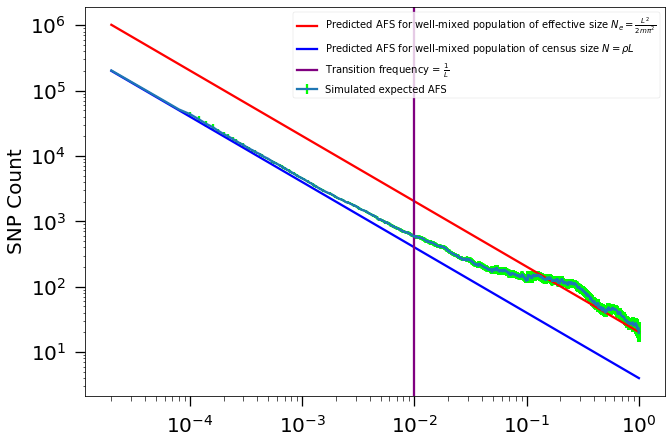

In [21]:
#err=np.array(smooth_std2(afs[1:], threshold=thresh, rescale=scale))
err=np.array(smooth_sem(afs[1:], threshold=thresh, rescale=scale))
plt.loglog(np.arange(1,total_sample_size+1)/(total_sample_size+1), Theta_eff / np.arange(1,total_sample_size+1), color="red")
plt.loglog(np.arange(1,total_sample_size+1)/(total_sample_size+1), Theta_real / np.arange(1,total_sample_size+1), color="blue")
plt.errorbar(np.arange(1, total_sample_size+1)/total_sample_size,smooth(afs[1:], threshold=thresh, rescale=scale), yerr=err, ecolor="lime")
#plt.loglog(np.arange(1, total_sample_size+1)/(total_sample_size+1),smooth(afs[1:], threshold=1000, rescale=200), color="green",linewidth=0.5) 
plt.axvline(transition_freq,color='purple')
#plt.axvline(0.2,color="orange")


plt.legend([r"Predicted AFS for well-mixed population of effective size $N_e=\frac{L^2}{2m\pi^2}$", r"Predicted AFS for well-mixed population of census size $N=\rho L$", r"Transition frequency = $\frac{1}{L}$", "Simulated expected AFS"], loc ="upper right", fontsize=10)
plt.ylabel("SNP Count")
plt.savefig("Mrhogreat_afs.pdf")